check this 
https://github.com/auspatious/dea-coastlines/blob/5fb20451cf6cba151d656a8d213b1a5a04f16ad3/coastlines/combined.py#L105

In [1]:
# %% All the loads, farm input, datetime,

import os
import boto3
import rasterio as rio
from pystac_client import Client
import xarray as xr
import numpy as np
from pathlib import Path
import geopandas as gpd
from datetime import date, datetime

from stackstac import stack
import pystac
import rioxarray

from utils import *
import matplotlib.pyplot as plt

# Set environment and create AWS Session
os.environ['CURL_CA_BUNDLE'] = '/etc/ssl/certs/ca-certificates.crt'
os.environ['AWS_REQUEST_PAYER'] = 'requester'

print("Creating AWS Session")
aws_session = rio.session.AWSSession(boto3.Session(), requester_pays=True)
print(aws_session)

# open Farm
run = 'ft0'
#farm_file = '/home/geodata/Clientes/0FARMS/MG-3102605-B4D344DBFD874F44906FCC0A5E0DCE36/CAR.gpkg'
farm_file = '/home/geodata/Clientes/0FARMS/FabioRicardi-Barreiras_BA/CARS-Fazenda_Savana.gpkg'

folder_nc = farm_file.split('CAR.gpkg')[0] + f'nc/{run}/'
Path(folder_nc).mkdir( parents = True, exist_ok = True)
print(folder_nc)
# open Farm
try:
    farm = gpd.read_file(farm_file, layer='AREA_IMOVEL_1')
except:
    farm = gpd.read_file(farm_file)

bbox = get_bbox(farm)

#  Satellite imagery query params
today = date.today()
datetime_range = str(f"2013-06-20/{str(today)}") #break  2017
datetime_range = str(f"1985-06-20/2013-06-20") #break  2017

max_cloud = 100
satellite = 'Landsat'

Creating AWS Session
/home/geodata/Clientes/0FARMS/FabioRicardi-Barreiras_BA/CARS-Fazenda_Savana.gpkgnc/ft0/


In [2]:
# Usando todos Landsats
URL = 'https://landsatlook.usgs.gov/stac-server'
cat = Client.open(URL)
collection_id = 'landsat-c2l2-st' # thermal 'landsat-c2l2-st' optical 'landsat-c2l2-sr'
collection = cat.get_collection(collection_id)
print(collection)

query_params = {
        "eo:cloud_cover": {"lt": max_cloud},
        "platform": {"in": ["LANDSAT_5","LANDSAT_7","LANDSAT_8", "LANDSAT_9"]},
       "landsat:collection_category": { "in": ['T1']}
        }

<CollectionClient id=landsat-c2l2-st>


### the search and items

In [3]:
search = cat.search(
    collections = [collection_id],
    bbox = bbox,
    datetime = datetime_range,
    query = query_params,
)
print(f"{search.matched()} items found \n ---")
# prepare items collection
items_dict = search.item_collection_as_dict()['features']


589 items found 
 ---


In [4]:
items = search.item_collection()
items[0]


<Item id=LC08_L2SP_220068_20130620_20200912_02_T1_ST>

In [5]:
assets = ['lwir','lwir11','qa_pixel']
# update URLs to use s3
for item in items_dict:
    for a in item['assets']:
        if 'alternate' in item['assets'][a] and 's3' in item['assets'][a]['alternate']:
            item['assets'][a]['href'] = item['assets'][a]['alternate']['s3']['href']
        item['assets'][a]['href'] = item['assets'][a]['href'].replace('usgs-landsat-ard', 'usgs-landsat')

item_collection = pystac.ItemCollection(items_dict)

In [6]:
# LOAD
with rio.Env(session = aws_session, AWS_S3_ENDPOINT= 's3.us-west-2.amazonaws.com'):
    dc = stack(item_collection,
                    assets= assets,
                    chunksize = 128,
                    bounds_latlon = bbox,
                    epsg = 4326,
                    rescale=False, 
                    fill_value=0, 
                    dtype="uint16",
                    )

/home/mariano/geo/lib/python3.10/site-packages/stackstac/prepare.py:408: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  times = pd.to_datetime(


- uns 5:30 pra carregar ate dar o erro `infer_datetime...`
- 21 minutos para carregar temperatura da fazenda na bahia, 2013 ate hoje, todos Landsats


In [7]:
ds_ = dc.to_dataset( dim = 'band' ).persist()


### Trip moment on cloud_mask stuff from DEA

In [12]:
# # WORKING PROJECT DEA
# # https://github.com/auspatious/dea-coastlines/blob/5fb20451cf6cba151d656a8d213b1a5a04f16ad3/coastlines/combined.py#L212
# nodata_mask = (ds['T'] == 0) 
# mask_bitfields = [3, 4]  # cloud, cloud shadow
# bitmask = 0
# for field in mask_bitfields:
#     bitmask |= 1 << field

# cloud_mask = ds["qa_pixel"].astype(int) & bitmask != 0

# from odc.algo import mask_cleanup
# dilated_cloud_mask = mask_cleanup(cloud_mask, [("opening", 5), ("dilation", 6)])

# cloud_mask.plot(col='time', col_wrap = 8)

In [13]:
#ds['T'].plot(col='time', col_wrap = 8)

### WORK On LAND SURFACE TEMPERATURE

##### the original LWIRs

In [8]:
ds = ds_.copy()

In [15]:
dc

<xarray.DataArray 'stackstac-9b09ea76ba1ee30239211b3714f31448' (time: 589,
                                                                band: 3,
                                                                y: 1133, x: 873)> Size: 3GB
dask.array<fetch_raster_window, shape=(589, 3, 1133, 873), dtype=uint16, chunksize=(1, 1, 128, 128), chunktype=numpy.ndarray>
Coordinates: (12/35)
  * time                          (time) datetime64[ns] 5kB 1985-06-23T12:37:...
    id                            (time) <U43 101kB 'LT05_L2SP_220068_1985062...
  * band                          (band) <U8 96B 'lwir' 'lwir11' 'qa_pixel'
  * x                             (x) float64 7kB -45.63 -45.63 ... -45.39
  * y                             (y) float64 9kB -11.48 -11.48 ... -11.79
    landsat:wrs_row               <U3 12B '068'
    ...                            ...
    title                         (band) <U30 360B 'Surface Temperature Band ...
    description                   (band) <U79 948B 'Collection 2 Level-2 Surf...
    common_name                   (band) object 24B None 'lwir11' None
    center_wavelength             (band) object 24B None 10.9 None
    full_width_half_max           object 8B None
    epsg                          int64 8B 4326
Attributes:
    spec:           RasterSpec(epsg=4326, bounds=(-45.631926503962745, -11.78...
    crs:            epsg:4326
    transform:      | 0.00, 0.00,-45.63|\n| 0.00,-0.00,-11.48|\n| 0.00, 0.00,...
    resolution_xy:  (0.0002748745648091244, 0.00027196315225630485)

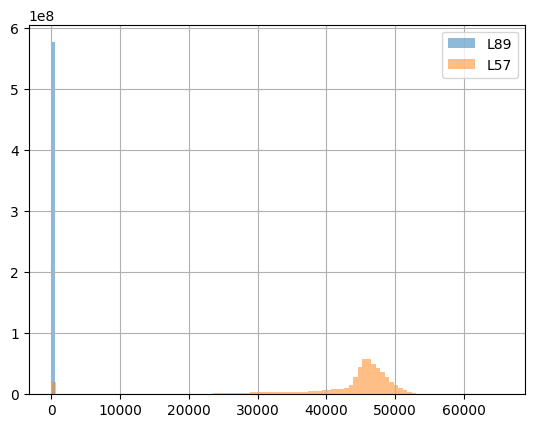

In [16]:
plt.hist(np.ravel(ds['lwir11'].values),bins=100, alpha=0.5, label='L89');
plt.hist(np.ravel(ds['lwir'].values),bins=100, alpha=0.5, label='L57');
plt.legend();plt.grid()

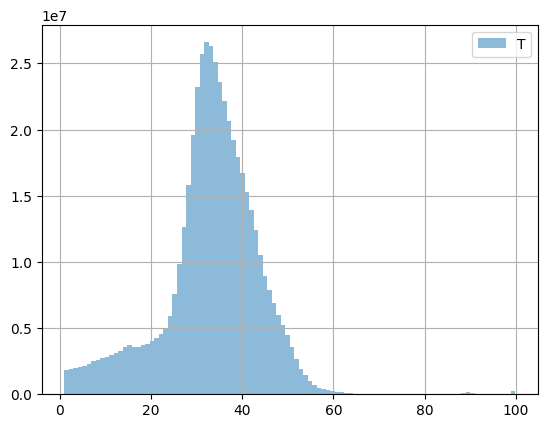

In [17]:
# SOMA, to Celcius and put nans
ds['T'] = (ds['lwir'] + ds['lwir11']) * 0.00341802 + 149 - 273.15

ds['T'] = ds['T'].astype('float32')
ds['T'] = xr.where(ds['T'] < 1, np.nan , ds['T'])

plt.hist(np.ravel(ds['T'].values),bins=100, alpha=0.5, label='T');
plt.legend();plt.grid()

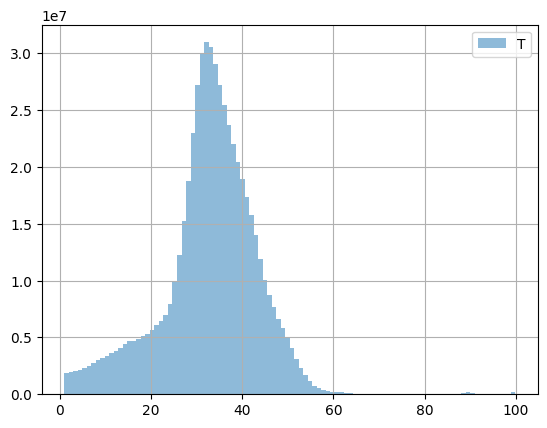

In [18]:
ds['T'] = ds['T'].chunk(dict(time=-1))
ds['T'] = ds['T'].interpolate_na(dim="time",
                method='linear',
                use_coordinate=True, 
            ) 

plt.hist(np.ravel(ds['T'].values),bins=100, alpha=0.5, label='T');
plt.legend();plt.grid()

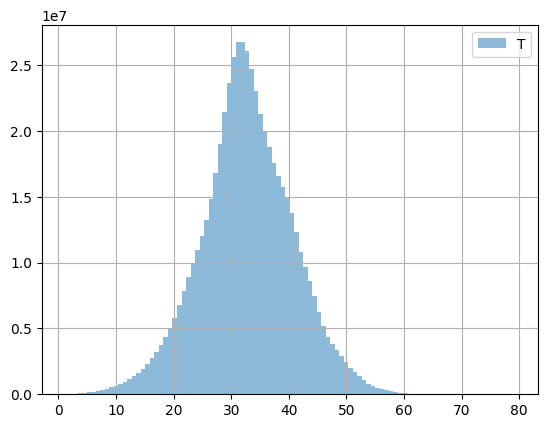

In [19]:
# rolling
w = 3
ds['T'] = ds['T'].rolling(time=w, center=True).mean(skipna=True)

plt.hist(np.ravel(ds['T'].values),bins=100, alpha=0.5, label='T');
plt.legend();plt.grid()

##### PREP 2 GO
com os cortes, interpolate_na e um leve smoothing, já tem cara de dado

In [20]:
ds2go = dropper(ds['T'], 'Landsat')
# REPROJECTION
print(f'\n reprojecting cube for {datetime_range}')
ds2go = ds2go.rio.write_crs('epsg:4326')
ds2go = ds2go.rio.reproject('EPSG:4326')
ds2go = ds2go.rename({'x': 'longitude','y': 'latitude'})
print('reprojecting... done')

# t0 = str(ds2go.time[0].values).split('T')[0]
# t1 = str(ds2go.time[-1].values).split('T')[0]
# n = len(ds2go.time)

# ds2go.to_netcdf('/home/geodata/Clientes/0FARMS/MG-3102605-B4D344DBFD874F44906FCC0A5E0DCE36/nc/LST_{t0}-{t1}_{n}.nc')

<<< landsat:correction dropped
<<< landsat:wrs_path dropped
<<< landsat:wrs_row dropped
<<< landsat:cloud_cover_land dropped
<<< landsat:collection_number dropped
<<< landsat:wrs_type dropped
<<< instruments dropped
--- raster:bands was not here
<<< eo:cloud_cover dropped
<<< accuracy:geometric_x_stddev dropped
no attribute spec to remove

 reprojecting cube for 1985-06-20/2013-06-20
reprojecting... done


In [26]:
t0 = str(ds2go.time[0].values).split('T')[0]
t1 = str(ds2go.time[-1].values).split('T')[0]
n = len(ds2go.time)
ds2go = dropper(ds2go)

ds2go.to_netcdf(f'/home/geodata/Clientes/0FARMS/FabioRicardi-Barreiras_BA/CARS-Fazenda_Savana.gpkgnc/LST_{t0}-{t1}_{n}.nc')

--- landsat:correction was not here
--- landsat:wrs_path was not here
--- landsat:wrs_row was not here
--- landsat:cloud_cover_land was not here
--- landsat:collection_number was not here
--- landsat:wrs_type was not here
--- instruments was not here
--- raster:bands was not here
--- eo:cloud_cover was not here
--- accuracy:geometric_x_stddev was not here
--- accuracy:geometric_y_stddev was not here
<<< accuracy:geometric_rmse dropped
no attribute spec to remove


In [27]:
t_m = ds2go.resample(time = 'ME').mean(skipna=True)

In [28]:
t0 = str(t_m.time[0].values).split('T')[0]
t1 = str(t_m.time[-1].values).split('T')[0]
n = len(t_m.time)
t_m.to_netcdf(f'/home/geodata/Clientes/0FARMS/FabioRicardi-Barreiras_BA/CARS-Fazenda_Savana.gpkgnc/LST_monthly_{t0}-{t1}_{n}.nc')